In [31]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'casia-20-image-tampering-detection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1226991%2F2048184%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240426%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240426T112650Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D81024942598bd6be2cf23eb420590e827ad700f34391be5288e5d0d5f5232d67a85d2617246b0f18109c4637b8f1494d0f133798ed449a16fd723a6f904bda8f45f9eb7bb36fd3998530c29f21a90d99cf29b32b1d0c83af86876d42d0d203285fe9dbd47874e0483637429d2b192065bff19f3cf349397e08342367b743e648af7068cbc48fbda5a8a86e5b8a562498d44359da826c5fff4fdb9e997da3dbf0d3191a1581bb7afd1c9e55f9fccf8d4f10274fe61cde305396f37f271ed9bf5360ce4850aee82710441c48ffa36dda02e8e14d317098bf362252648cf70aebbdbba0e21175cb6015a8a295daa33e92ed1b155ffd43b9080a118a5774dd44c2e4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 2745530246 bytes downloaded
Downloaded and uncompressed: casia-20-image-tampering-detection-dataset
Data source import complete.


In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image, ImageEnhance, ImageChops
import random
from shutil import copyfile
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl
import warnings
warnings.filterwarnings("ignore")

In [33]:
def get_format_counts(path):
    ''' gets the counts of each image format in the specified path'''
    counts = {}

    for image in os.listdir(path):
        img_type = image.split('.')[-1]
        if img_type in counts:
            counts[img_type] += 1
        else:
            counts.update({img_type: 1})

    return counts

# Get the counts of formats in the authentic images folder
print(get_format_counts('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'))

# Get the counts of formats in the tempered images folder
print(get_format_counts('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'))

{'jpg': 7437, 'bmp': 54, 'db': 1}
{'tif': 3059, 'jpg': 2064, 'db': 1, 'txt': 1}


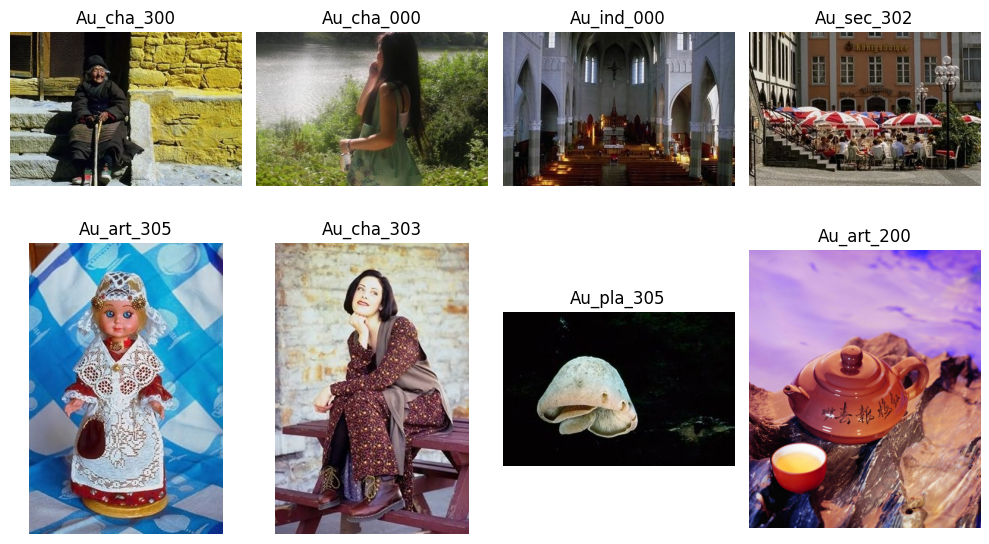

In [34]:
def show_images(path):
    # Get random 8 images from the path
    image_files = random.sample(os.listdir(path), 8)

    # Create a 2x4 grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(10, 6))

    # Iterate over the image files and plot them in the subplots
    for i, ax in enumerate(axes.flatten()):
        # Load and plot the image
        image_path = os.path.join(path, image_files[i])
        image = plt.imread(image_path)
        ax.imshow(image)
        ax.set_title(image_files[i][:10])  # Set the title as the image filename
        ax.axis('off')  # Turn off axis labels

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


# Path to the authentic images directory
image_dir = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
show_images(image_dir)

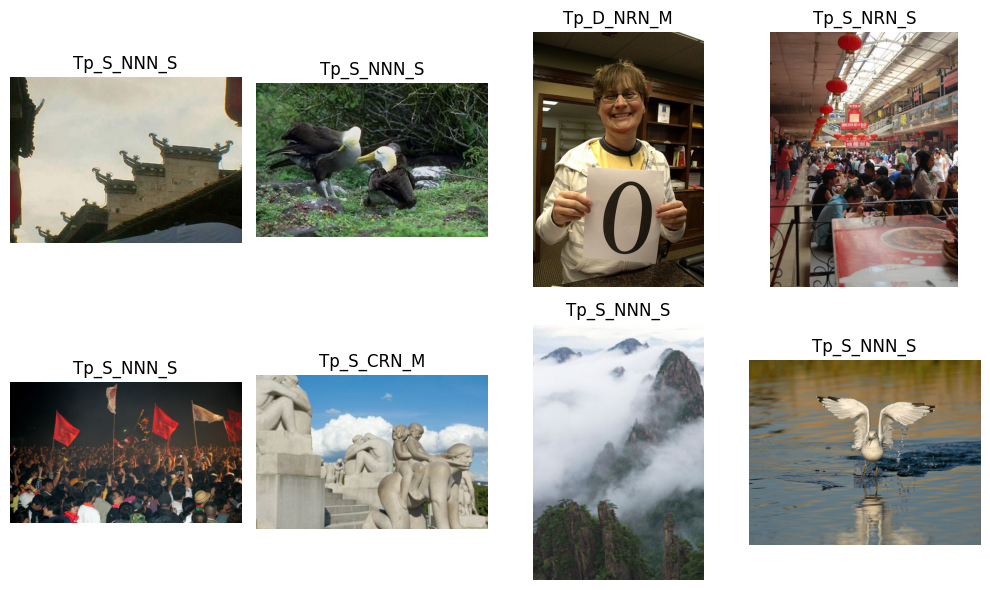

In [35]:
image_dir = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
show_images(image_dir)

In [36]:
def image_to_ela(path, quality, resave_path):
    ''' Gets images specified as path and resaves it at a new path resave_path at specified quality'''
    try:
        # Check if the file format is supported (JPEG or PNG)
        if path.endswith('jpg') or path.endswith('jpeg') or path.endswith('png'):
            # Open the image and convert it to RGB mode
            image = Image.open(path).convert('RGB')

            # Resave the image with the specified quality
            image.save('resaved.jpg', 'JPEG', quality=quality)
            resaved = Image.open('resaved.jpg')

            # Calculate the ELA (Error Level Analysis) image by taking the difference between the original and resaved image
            ela_image = ImageChops.difference(image, resaved)

            # Get the minimum and maximum pixel values in the ELA image
            band_values = ela_image.getextrema()
            max_value = max([val[1] for val in band_values])

            # If the maximum value is 0, set it to 1 to avoid division by zero
            if max_value == 0:
                max_value = 1

            # Scale the pixel values of the ELA image to the range [0, 255]
            scale = 255.0 / max_value
            ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

            # Save the ELA image with the same filename in the specified resave path
            ela_image.save(os.path.join(resave_path, os.path.basename(path)), 'JPEG')
    except Exception as e:
        print(f'Could not convert {path} to ELA: {str(e)}')


In [37]:
def preprocess_data(parent_path, files, resave_path):
    ''' Loops through a directory and applies the image_to_ela function to each image in the directory'''
    for file in files:
        image_to_ela(os.path.join(parent_path, file), 90, resave_path)

In [38]:
# get list of all authentic images
auth_files = os.listdir('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au')

# get list of all Tempered images
doc_files = os.listdir('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp')

# create the all_reals and all_docs where we save the real and doctored ELA images
os.mkdir('/kaggle/working/all_reals')
os.mkdir('/kaggle/working/all_Doc')

# converting  validation real images to ela
parent_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
preprocess_data(parent_path, auth_files, '/kaggle/working/all_reals')

# converting training doctored images to ela
parent_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
preprocess_data(parent_path, doc_files, '/kaggle/working/all_Doc')

print('There are ' + str(len(os.listdir('/kaggle/working/all_reals'))) + ' supported Authentic Images')
print('There are ' + str(len(os.listdir('/kaggle/working/all_Doc'))) + ' supported Tempered Images')

There are 7437 supported Authentic Images
There are 2064 supported Tempered Images


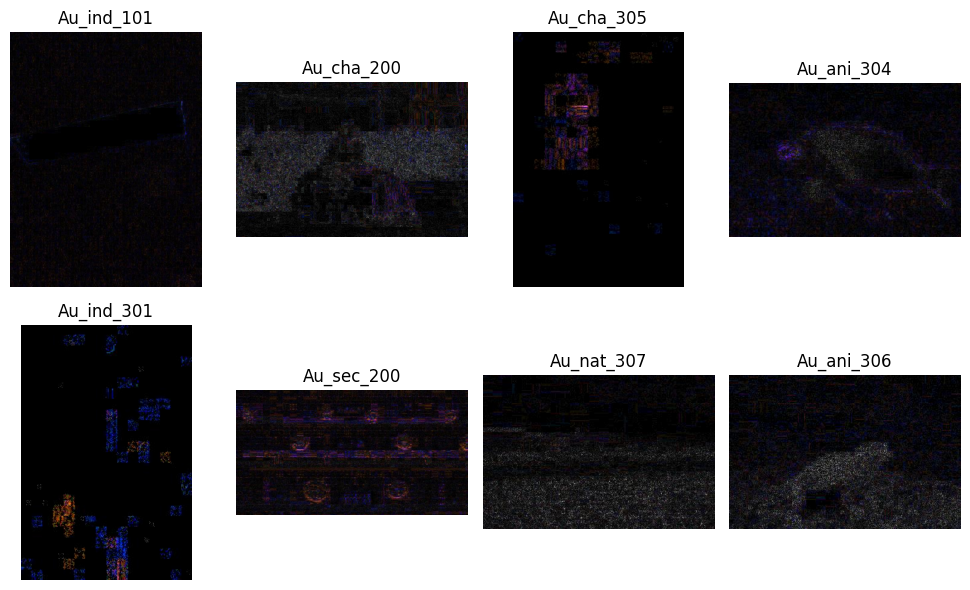

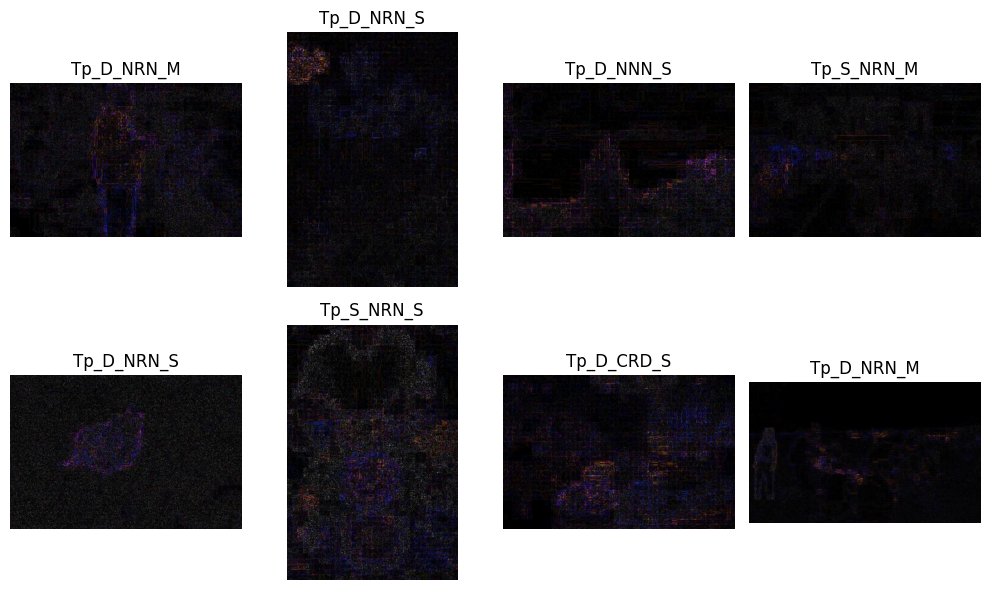

In [39]:
# Path to the authentic ela images directory
image_dir = '/kaggle/working/all_reals'
show_images(image_dir)

# Path to the tempered ela images directory
image_dir = '/kaggle/working/all_Doc'
show_images(image_dir)

In [41]:
# creating the parent directory for both the Training and Validation datasets
ela_path = os.path.join(os.getcwd(), 'ela_images')

# create path for training set and the different labels
auth_path_train = os.path.join(ela_path, 'train',  'Real')
temp_path_train = os.path.join(ela_path, 'train', 'Doctored')
os.makedirs(auth_path_train)
os.makedirs(temp_path_train)

# create path for validation set and its different labels
auth_path_val = os.path.join(ela_path, 'Val',  'Real')
temp_path_val = os.path.join(ela_path, 'Val', 'Doctored')
os.makedirs(auth_path_val)
os.makedirs(temp_path_val)

In [44]:
import os
import random
from shutil import copyfile

# Get the list of files in the 'all_reals' directory
real_files = os.listdir('/kaggle/working/all_reals')

# Get the list of files in the 'all_Doc' directory
doc_files = os.listdir('/kaggle/working/all_Doc')

# Calculate the total length for training and validation sets for doctored images
total_len_train_doc = int((90 / 100) * len(doc_files))
total_len_val_doc = int((10 / 100) * len(doc_files))

# Randomly select files for validation from the authentic image files
val_auth = random.choices(real_files, k=total_len_val_doc)

# Select the remaining files for training from the authentic image files
train_auth = [f for f in real_files if f not in val_auth][:total_len_train_doc]

# Randomly select files for validation from the doctored image files
val_doc = random.choices(doc_files, k=total_len_val_doc)

# Select the remaining files for training from the doctored image files
train_doc = [f for f in doc_files if f not in val_doc][:total_len_train_doc]

# Path to the destination directories for training and validation authentic images
auth_path_train = '/kaggle/working/ela_images/train/Real'
auth_path_val = '/kaggle/working/ela_images/Val/Real'

# Path to the destination directories for training and validation doctored images
temp_path_train = '/kaggle/working/ela_images/train/Doctored'
temp_path_val = '/kaggle/working/ela_images/Val/Doctored'

# Create directories if they don't exist
os.makedirs(auth_path_train, exist_ok=True)
os.makedirs(auth_path_val, exist_ok=True)
os.makedirs(temp_path_train, exist_ok=True)
os.makedirs(temp_path_val, exist_ok=True)

# Copy the training authentic images to ela_images/train/Real
for item in train_auth:
    copyfile('/kaggle/working/all_reals/{}'.format(item), "{}/{}".format(auth_path_train, os.path.basename(item)))

# Copy the validation authentic images to ela_images/Val/Real
for item in val_auth:
    copyfile('/kaggle/working/all_reals/{}'.format(item), "{}/{}".format(auth_path_val, os.path.basename(item)))

# Copy the training doctored images to ela_images/train/Doctored
for item in train_doc:
    copyfile('/kaggle/working/all_Doc/{}'.format(item), "{}/{}".format(temp_path_train, os.path.basename(item)))

# Copy the validation doctored images to ela_images/Val/Doctored
for item in val_doc:
    copyfile('/kaggle/working/all_Doc/{}'.format(item), "{}/{}".format(temp_path_val, os.path.basename(item)))

# Print the lengths of the validation and training sets for authentic and doctored images
print("There are a total of " + str(len(train_auth)) + " Authentic Images in the training set")
print("There are a total of " + str(len(train_doc)) + " Doctored Images in the training set")
print("There are a total of " + str(len(val_auth)) + " Authentic Images in the Validation set")
print("There are a total of " + str(len(val_doc)) + " Doctored Images in the Validation set")


There are a total of 1857 Authentic Images in the training set
There are a total of 1857 Doctored Images in the training set
There are a total of 206 Authentic Images in the Validation set
There are a total of 206 Doctored Images in the Validation set


In [45]:
# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator()

# Generate training images
train_images = datagen.flow_from_directory(
    '/kaggle/working/ela_images/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

# Generate validation images
validation_images = datagen.flow_from_directory(
    '/kaggle/working/ela_images/Val',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)
train_images1 = datagen.flow_from_directory(
    '/kaggle/working/ela_images/train',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

# Generate validation images
validation_images1 = datagen.flow_from_directory(
    '/kaggle/working/ela_images/Val',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

train_images2= datagen.flow_from_directory(
    '/kaggle/working/ela_images/train',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

# Generate validation images
validation_images2= datagen.flow_from_directory(
    '/kaggle/working/ela_images/Val',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

Found 3714 images belonging to 2 classes.
Found 403 images belonging to 2 classes.
Found 3714 images belonging to 2 classes.
Found 403 images belonging to 2 classes.
Found 3714 images belonging to 2 classes.
Found 403 images belonging to 2 classes.


In [46]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras import layers, models

# Step 1: Load pre-trained GoogleNet and VGG models (without top classification layers)
google_net = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the layers of the base models (optional, depends on your dataset size)
for layer in google_net.layers:
    layer.trainable = False
for layer in vgg.layers:
    layer.trainable = False

# Step 3: Create fusion model
input_layer = tf.keras.Input(shape=(224, 224, 3))
google_net_features = google_net(input_layer)
vgg_features = vgg(input_layer)

# Step 4: Reshape the GoogleNet features to match the shape of VGG features
google_net_features = layers.GlobalAveragePooling2D()(google_net_features)
google_net_features = layers.Dense(1024, activation='relu')(google_net_features)
google_net_features = tf.expand_dims(google_net_features, axis=1)
google_net_features = tf.expand_dims(google_net_features, axis=1)
google_net_features = tf.keras.layers.UpSampling2D(size=(7, 7))(google_net_features)

# Step 5: Concatenate the feature representations from both models
fusion_features = layers.Concatenate()([google_net_features, vgg_features])

# Step 6: Add additional layers for fusion and making predictions
fusion_features = layers.GlobalAveragePooling2D()(fusion_features)
fusion_features = layers.Dense(1024, activation='relu')(fusion_features)
predictions = layers.Dense(1, activation='sigmoid')(fusion_features)

# Step 7: Create the fusion model
model = models.Model(inputs=input_layer, outputs=predictions)

# Step 8: Compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now the 'model' is a fusion of GoogleNet and VGG models for your specific task

58889256/58889256 [==============================] - 1s 0us/step


In [47]:
history = model.fit(
    train_images2,
    steps_per_epoch=len(train_images) / 32,
    epochs=10,
    validation_data = validation_images2
)

Epoch 1/10
3/3 [==============================] - 366s 127s/step - loss: 2.0690 - accuracy: 0.6016 - val_loss: 0.8203 - val_accuracy: 0.6526
Epoch 2/10
3/3 [==============================] - 413s 146s/step - loss: 0.8069 - accuracy: 0.6484 - val_loss: 0.5456 - val_accuracy: 0.8189
Epoch 3/10
3/3 [==============================] - 407s 145s/step - loss: 0.4174 - accuracy: 0.8203 - val_loss: 0.3703 - val_accuracy: 0.8412
Epoch 4/10
3/3 [==============================] - 410s 146s/step - loss: 0.4995 - accuracy: 0.8203 - val_loss: 0.3996 - val_accuracy: 0.8337
Epoch 5/10
3/3 [==============================] - 409s 146s/step - loss: 0.2880 - accuracy: 0.8672 - val_loss: 0.3780 - val_accuracy: 0.8313
Epoch 6/10
3/3 [==============================] - 411s 146s/step - loss: 0.3976 - accuracy: 0.7891 - val_loss: 0.3110 - val_accuracy: 0.8660
Epoch 7/10
3/3 [==============================] - 410s 146s/step - loss: 0.2283 - accuracy: 0.9375 - val_loss: 0.2905 - val_accuracy: 0.8933
Epoch 8/10
3/

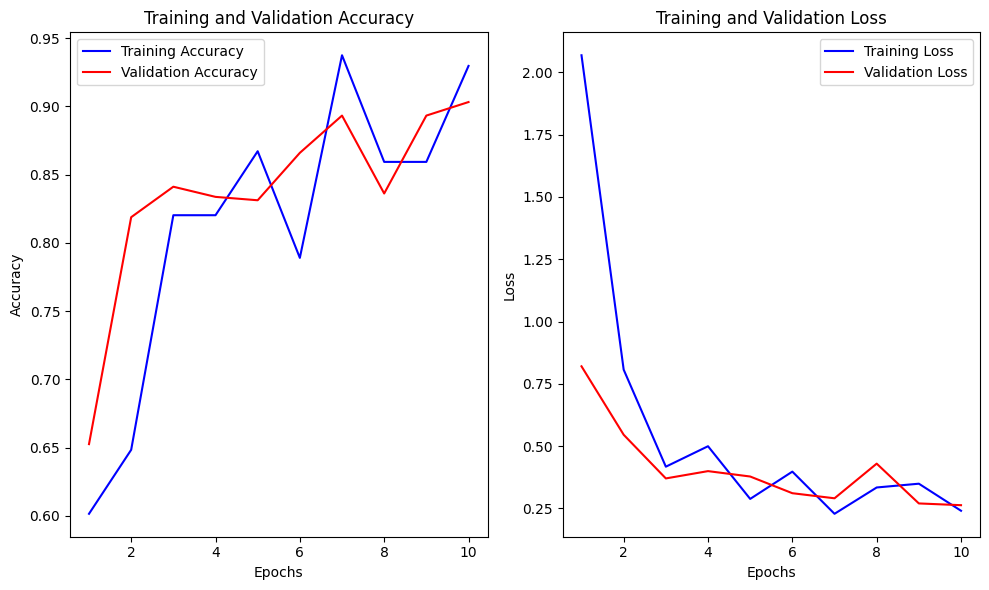

In [48]:
def plot_accuracy(history):
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # Get the training and validation accuracy values from the history object
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Get the training and validation loss values from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

#     # Get the training and validation precision values from the history object
#     train_precision = history.history['precision_1']
#     val_precision = history.history['val_precision_1']

#     # Get the training and validation recall values from the history object
#     train_recall = history.history['recall_1']
#     val_recall = history.history['val_recall_1']

    # Get the number of epochs
    epochs = range(1, len(train_acc) + 1)

    # Plot the training and validation accuracy
    axes[0].plot(epochs, train_acc, 'b', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Plot the training and validation loss
    axes[1].plot(epochs, train_loss, 'b', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

#     # Plot the training and validation precision
#     axes[1, 0].plot(epochs, train_precision, 'b', label='Training Precision')
#     axes[1, 0].plot(epochs, val_precision, 'r', label='Validation Precision')
#     axes[1, 0].set_title('Training and Validation Precision')
#     axes[1, 0].set_xlabel('Epochs')
#     axes[1, 0].set_ylabel('Precision')
#     axes[1, 0].legend()

#     # Plot the training and validation recall
#     axes[1, 1].plot(epochs, train_recall, 'b', label='Training Recall')
#     axes[1, 1].plot(epochs, val_recall, 'r', label='Validation Recall')
#     axes[1, 1].set_title('Training and Validation Recall')
#     axes[1, 1].set_xlabel('Epochs')
#     axes[1, 1].set_ylabel('Recall')
#     axes[1, 1].legend()

    # Adjust the layout
    fig.tight_layout()

    # Show the plot
    plt.show()


plot_accuracy(history)